❗ Оставлены рекомендации ревьюера

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  
  
  
  
**Задача**:  
  
Построить модель, которая по фотографии определит приблизительный возраст человека.
  
  
  
**Описание данных**:
  
`file_name` — фотография человека  
`real_age` — возраст человека  
  
  
  
**План**:
  
1. Провести исследовательский анализ данных: загрузить файлы, построить график распределения, сделать обзор фотографий
2. Обучить нейронную сеть и рассчитать её качество

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Взглянем на количество и тип данных

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
df.shape

(7591, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Загрузим данные

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Построим гистограмму и ящик с усами распределения возраста в выборке.

Text(0, 0.5, 'Плотность частоты')

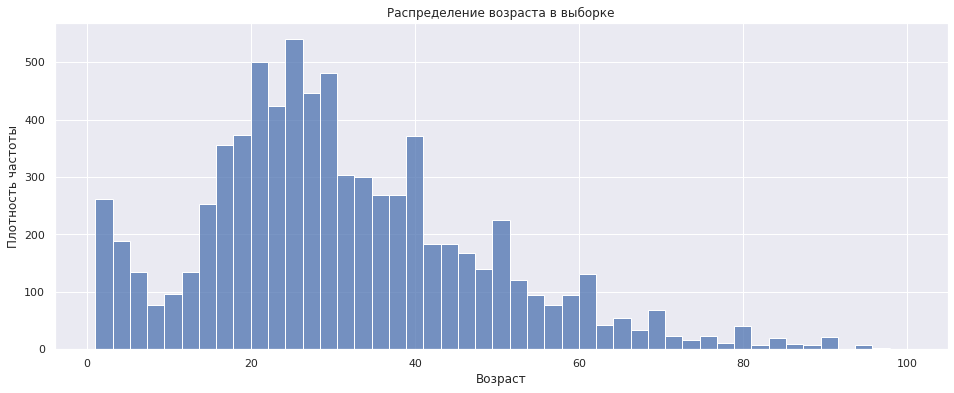

In [ ]:
plt.figure(figsize=(16,6))
sns.set()

ax = sns.histplot(df['real_age'])
ax.set_title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Плотность частоты')

1. Больше всего людей в возрасте от 18 до 40 лет.
2. Можно заметить пик возле нулевого значения — в выборке много изображений детей до 10 лет
3. Наблюдаются также резко возрастающее количество значений в возрастах, которые кратны 10, начиная с 20 лет. Возможно, у некоторых фотографий точный возраст не было возможности указать, поэтому указывали примерный

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


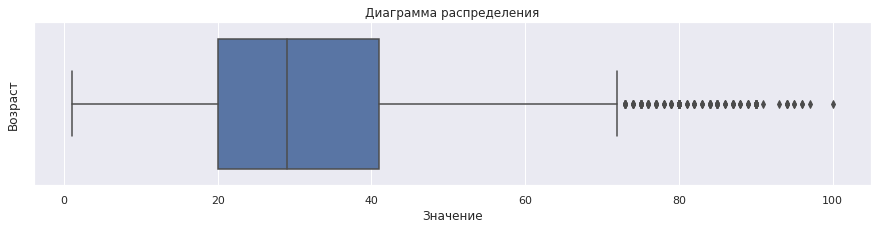

In [ ]:
plt.figure(figsize=(15,3))

sns.boxplot(df['real_age']).set(xlabel='Значение', ylabel='Возраст')
plt.title(label='Диаграмма распределения')
plt.show()

In [ ]:
df['real_age'].median()

29.0

Медиана — 29, графики смещены вправо, распределение получается неравномерным.

Далее посмотрим на фотографии, выведем 15 штук

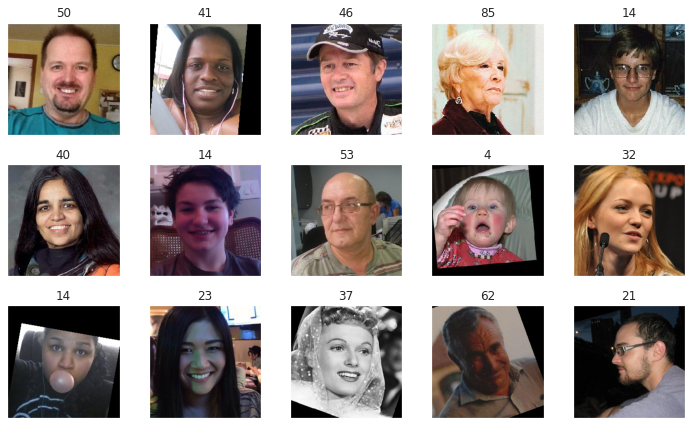

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

Изображения абсолютно разные: есть люди разных полов и возрастов. Не на всех фото лица чёткие, какие-то повёрнуты, на каких-то фотографиях есть сторонние надписи или артефакты, которые скорее всего помешают обучению.

### Вывод

Фотографии разнообразные: есть люди разных возврастов и полов, есть маленькие дети. Изображения есть как цветные, так и чёрно-белые. Некоторые фотографии повернуты в разные стороны. Размеры изображений тоже различаются: какие-то меньше, какие-то больше.  

Так как выборка распределена неравномерно, скорее всего, модель лучше обучится предсказывать тот возраст, для которого в выборке больше фотографий, например, 25-30 лет. Хуже будет предсказывать возраст более старших людей — от 40 и выше, так как там материала для обучения будет меньше.

## Обучение модели

**Задача**  
Нужно построить и обучить свёрточную нейронную сеть. Нужно добиться значения MAE на тестовой выборке не больше 8.

`load_train(path)` - загрузка обучающей выборки  
  
`load_test(path)` - загрузка тестовой выборки,  
  
`create_model(input_shape)` - создание модели,  
  
`train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - обучение модели и оценка на тестовой выборке.

learning rate в алгоритме Adam запишем как 0.0001, приведем изображения к размеру 224х224, количество изображений в батче оставим 16. Количество эпох взяла 25. Добавила вертикальную аугментацию.  
Воспользовалась советом из урока: функцей потерь будет MSE, а контрольная метрика — МАЕ.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       vertical_flip=True,
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path + 'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
        
- Т.к. для нас важна общая ориентация лица на фото, то вертикальный флип и поворот более, чем на 20 градусов, желательно не применять, он искажает ориентацию лица на фото.  
- А вот горизонтальный флип на тренировочной части уместен. По сути это позволяет увеличить выборку в 2 раза. Причем изображения полученные таким образом неотличимы от настоящих.
 </div>

```

Train for 356 steps, validate for 119 steps

Epoch 1/25

2022-08-26 22:28:17.534842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-08-26 22:28:17.947418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 77s - loss: 245.3132 - mae: 11.5915 - val_loss: 889.4986 - val_mae: 24.9736

Epoch 2/25

356/356 - 70s - loss: 101.7152 - mae: 7.7124 - val_loss: 196.1358 - val_mae: 10.7084

Epoch 3/25

356/356 - 65s - loss: 74.9406 - mae: 6.5531 - val_loss: 93.6596 - val_mae: 7.3173

Epoch 4/25

356/356 - 70s - loss: 56.0351 - mae: 5.6996 - val_loss: 88.9184 - val_mae: 7.0808

Epoch 5/25

356/356 - 41s - loss: 44.4107 - mae: 5.0625 - val_loss: 84.2138 - val_mae: 6.9039

Epoch 6/25

356/356 - 45s - loss: 34.3119 - mae: 4.5092 - val_loss: 84.5487 - val_mae: 6.8186

Epoch 7/25

356/356 - 44s - loss: 27.4202 - mae: 4.0059 - val_loss: 80.4252 - val_mae: 6.6882

Epoch 8/25

356/356 - 40s - loss: 23.0244 - mae: 3.6792 - val_loss: 108.4658 - val_mae: 8.1152

Epoch 9/25

356/356 - 41s - loss: 20.5286 - mae: 3.4657 - val_loss: 81.5828 - val_mae: 6.6484

Epoch 10/25

356/356 - 42s - loss: 17.7062 - mae: 3.2367 - val_loss: 79.0471 - val_mae: 6.5677

Epoch 11/25

356/356 - 40s - loss: 16.8350 - mae: 3.1433 - val_loss: 78.9975 - val_mae: 6.6036

Epoch 12/25

356/356 - 40s - loss: 15.6447 - mae: 3.0158 - val_loss: 77.4465 - val_mae: 6.4669

Epoch 13/25

356/356 - 42s - loss: 14.2280 - mae: 2.8868 - val_loss: 73.5426 - val_mae: 6.3616

Epoch 14/25

356/356 - 41s - loss: 14.3318 - mae: 2.8920 - val_loss: 78.0058 - val_mae: 6.4738

Epoch 15/25

356/356 - 40s - loss: 15.0710 - mae: 2.9560 - val_loss: 79.2012 - val_mae: 6.5821

Epoch 16/25

356/356 - 41s - loss: 13.3352 - mae: 2.7572 - val_loss: 77.1040 - val_mae: 6.5099

Epoch 17/25

356/356 - 41s - loss: 13.9701 - mae: 2.8171 - val_loss: 79.0471 - val_mae: 6.6873

Epoch 18/25

356/356 - 39s - loss: 12.8981 - mae: 2.7351 - val_loss: 72.7924 - val_mae: 6.4132

Epoch 19/25

356/356 - 41s - loss: 12.5249 - mae: 2.6784 - val_loss: 84.2544 - val_mae: 7.1497

Epoch 20/25

356/356 - 41s - loss: 11.1430 - mae: 2.5128 - val_loss: 89.9138 - val_mae: 7.6058

Epoch 21/25

356/356 - 39s - loss: 10.2932 - mae: 2.4392 - val_loss: 79.1843 - val_mae: 6.5166

Epoch 22/25

356/356 - 42s - loss: 10.4100 - mae: 2.4403 - val_loss: 73.0989 - val_mae: 6.3658

Epoch 23/25

356/356 - 42s - loss: 10.3276 - mae: 2.4286 - val_loss: 73.1858 - val_mae: 6.4747

Epoch 24/25

356/356 - 41s - loss: 10.0142 - mae: 2.4045 - val_loss: 76.0615 - val_mae: 6.4627

Epoch 25/25

356/356 - 40s - loss: 9.8436 - mae: 2.3708 - val_loss: 70.9093 - val_mae: 6.3367

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 10s - loss: 70.9093 - mae: 6.3367

Test MAE: 6.3367



```

## Анализ обученной модели

Обучили модель ResNet50. При обучении learning rate в алгоритме Adam указали как 0.0001, привели изображения к размеру 224х224, количество изображений в батче оставили 16. Количество эпох взяли 25 и добавили вертикальную аугментацию.
Функцей потерь при обучении поставили MSE, контрольная метрика — МАЕ.


Модель предсказывает возраст человека по фотографии со средней ошибкой 6.34, что удовлетворяет условию задачи (нужно было получить менее 8).
 Так как распределение выборки было неравномерным, модель скорее всего будет чаще ошибаться при определении более зрелых людей (старше 40), так как материала для обучения для этого возраста было меньше.

Это дает возможность:

1. Анализировать покупки и предлагать на кассе товары, которые могут заинтересовать покупателей этой возрастной группы.
2. Контролировать добросовестность кассиров при продаже алкоголя и табака.
3. Если есть мобильное приложение, то предлагать индивидуальные акции на продукцию или напоминать об акциях на любимые товары.


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Могу поделиться такими ссылками для углубленного изучения темы спринта:
    
- Видеокурс от Stanford University: https://www.youtube.com/watch?v=vT1JzLTH4G4&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk
    
- Курс от Физтех-школы Прикладной Математики и Информатики МФТИ: https://vk.com/dlschool_mipt
    
- Курс Нейронные сети и компьютерное зрение от Sumsung: https://stepik.org/course/50352/promo#toc

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера v.2 <a class="tocSkip"> </h2>    
    
     
  
Теперь почти идеально, молодец! Принимаю твой проект)
    
    
В этом проекте все шаги отработаны. С интересом читал твои размышления, код и выводы. Что ещё для дальнейшего улучшения качества возможно сделать?
    
Опишу здесь некоторые идеи:
    
1. Качество данных на входе: оценить еще раз возраст по фото.
2. Анализ ошибок: к примеру модель сильно ошибается на сегменте пожилых людей, зато почти идеально работает с детьми. Тогда мы поймем, каких возрастов фото было бы хорошо добавить в выборку для дообучения.
3. Дополнительно изучить распределение целевого признака, возможно что выборка была составлена неслучайным образом (видна небольшая бимодальность), посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.
    
Но цель нашего проекта достигнута. Рад был тебе помочь)
    
Преподаватель в Slack будет рад помочь, если у тебя появятся вопросы. Удачи тебе в финальном проекте!
  
</div>